# Example: Tapqir analysis (Part 1)

This tutorial is a Jupyter notebook that illustrates steps involved in Tapqir analysis. To work with the live version of the notebook run it in Google Colab using the link above.

**Note**: Jupyter notebook is a Python environment. It can also run shell commands with the ! sign prepended to the command (or sometimes % sign for jupyter [magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html)). To run the commands from this notebook in Anaconda Prompt or Linux terminal don't forget to leave out prepended ! sign.

## Set up & Installation on Google Colab

* Change runtime to GPU (in the menu select `Runtime -> Change runtime type -> GPU`)
* Connect Google Drive to be able to save the analysis output (to view Files & Folders click on a File icon on the left):

In [1]:
# Run this cell to connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")
# change directory to MyDrive
%cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


* Run the cell below to install Tapqir in Google Colab (takes about a minute):

In [2]:
# Run this cell to install Tapqir in Google Colab
!pip install --quiet git+https://github.com/gelles-brandeis/tapqir.git > install.log

## Initialize Tapqir folder

First create a new folder for the analysis and initialize Tapqir in it:

In [6]:
# create a new directory
%mkdir Rpb1SNAP549
# change direcotry
%cd Rpb1SNAP549
# initialize tapqir
!tapqir init

/content/drive/MyDrive/Rpb1SNAP549
Initialized Tapqir analysis folder.

Tapqir is a Bayesian program for single-molecule data analysis.
---------------------------------------------------------------
- Checkout the documentation: <https://tapqir.readthedocs.io/>
- Get help on our forum: <https://github.com/gelles-brandeis/tapqir/discussions>
- Star us on GitHub: <https://github.com/gelles-brandeis/tapqir>



Initializing Tapqir creates a `.tapqir` hidden folder that contains files for internal use by Tapqir (`config` file, `log` file, model checkpoints).

In [7]:
# list all files (including hidden files)
%ls -alh

total 4.0K
drwx------ 2 root root 4.0K Oct 12 19:23 .tapqir/


## Import & preprocess data

In this tutorial we will analyze the data from Rpb1-SNAP$^{549}$ binding to DNA$^{488}$ experiment [1].

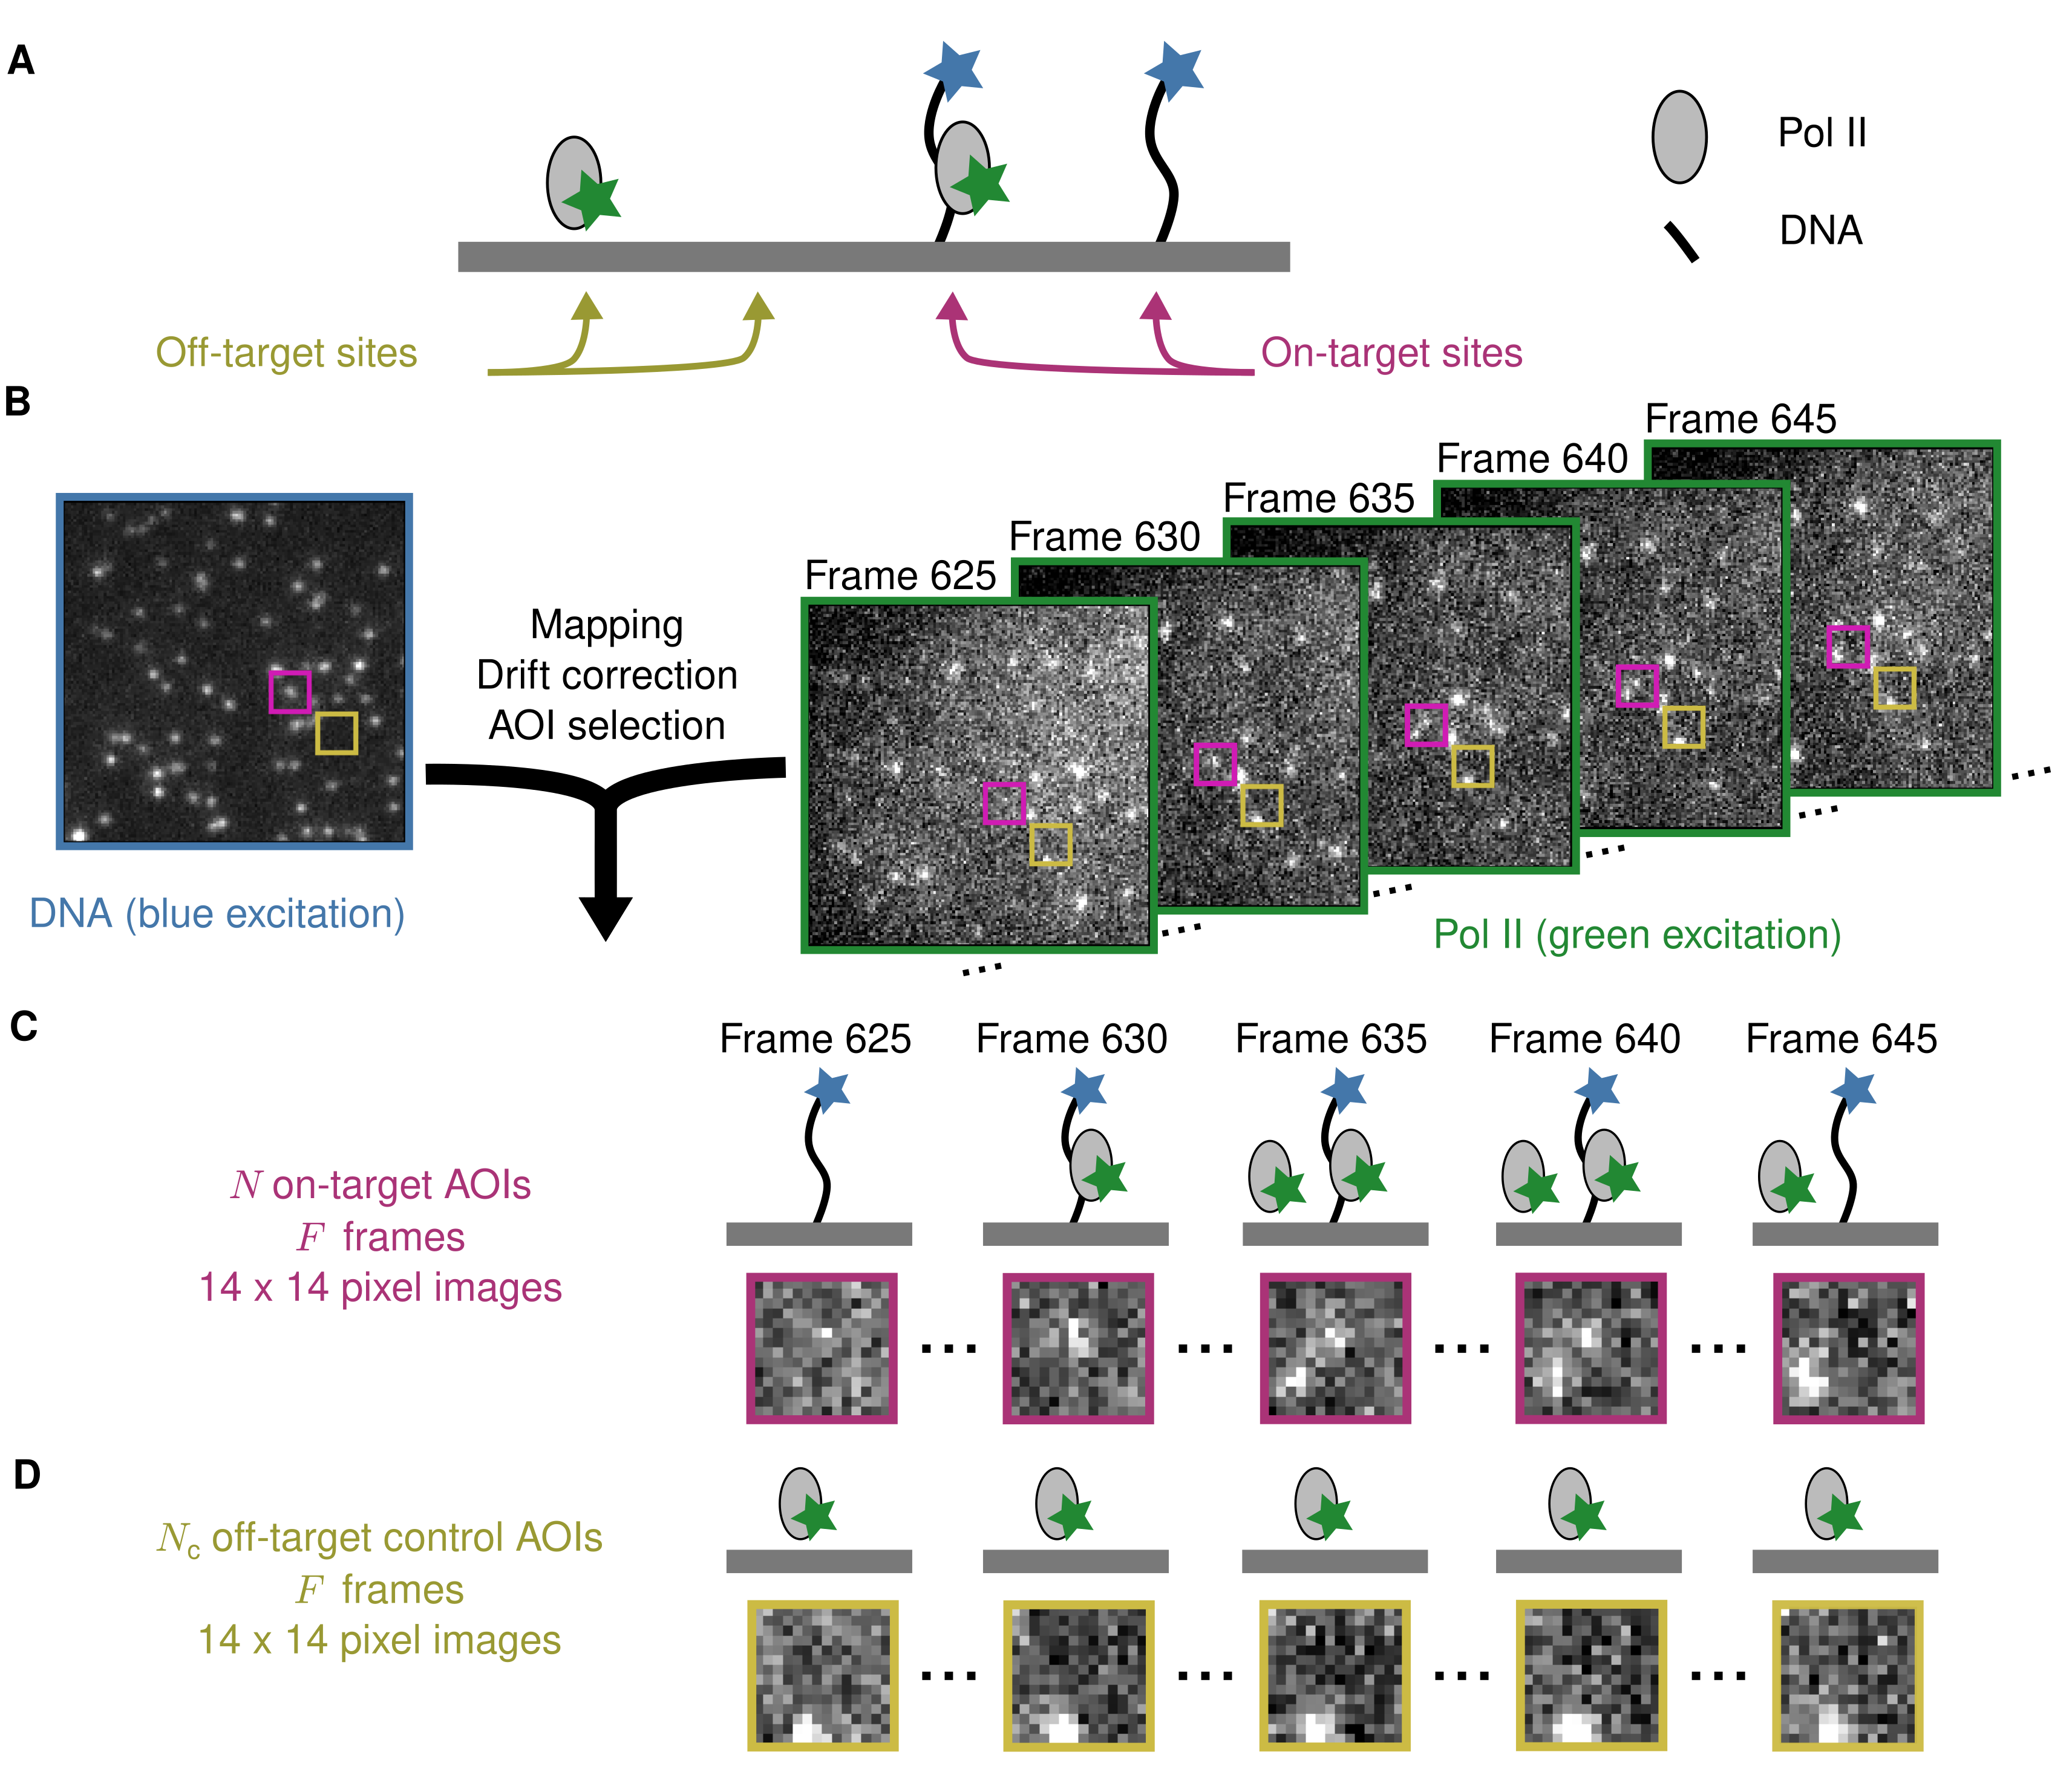

In [ ]:
from IPython.display import Image

Image("http://centaur.biochem.brandeis.edu/cosmos_experiment.png", width=700)

This data was acquired with [Glimpse](https://github.com/gelles-brandeis/Glimpse) and pre-processed with imscroll program [2]. The raw input data is:

* `garosen00267` - folder containing glimpse and header files
* `green_DNA_locations.dat` - file designating target molecule (DNA) locations in the binder channel
* `green_nonDNA_locations.dat` - file designating off-target (nonDNA) locations in the binder channel
* `green_driftlist.dat` - file recording the stage movement that took place during the experiment

**Note**: on Windows just open http://centaur.biochem.brandeis.edu/Rpb1SNAP549_glimpse.zip link in the browser to save the file and then unzip it.

In [8]:
%%capture
# Download and unzip raw input files
!wget http://centaur.biochem.brandeis.edu/Rpb1SNAP549_glimpse.zip
!unzip Rpb1SNAP549_glimpse.zip && rm Rpb1SNAP549_glimpse.zip

Let's make sure we have all our needed files:

In [9]:
# list Rpb1SNAP549_glimpse folder content
%ls Rpb1SNAP549_glimpse

garosen00267/             green_driftlist.dat*
green_DNA_locations.dat*  green_nonDNA_locations.dat*


Next, we will use `tapqir glimpse` command to extract AOIs. We will demonstrate two different approaches to run this command.

1) `tapqir glimpse` command accepts multiple options where each option input can be a long string. To make it more convenient we will use `tapqir config` command to set default values of each option and then run `tapqir glimpse`.

In [10]:
!tapqir config glimpse.title Rpb1SNAP549
!tapqir config glimpse.aoi_size 14
!tapqir config glimpse.header_dir Rpb1SNAP549_glimpse/garosen00267
!tapqir config glimpse.ontarget_aoiinfo Rpb1SNAP549_glimpse/green_DNA_locations.dat
!tapqir config glimpse.offtarget_aoiinfo Rpb1SNAP549_glimpse/green_nonDNA_locations.dat
!tapqir config glimpse.driftlist Rpb1SNAP549_glimpse/green_driftlist.dat
!tapqir config glimpse.frame_start 1
!tapqir config glimpse.frame_end 790

We can use `tapqir config --list` to list all entered options:

In [11]:
!tapqir config --list

[glimpse]
title = Rpb1SNAP549
aoi_size = 14
header_dir = Rpb1SNAP549_glimpse/garosen00267
ontarget_aoiinfo = Rpb1SNAP549_glimpse/green_DNA_locations.dat
offtarget_aoiinfo = Rpb1SNAP549_glimpse/green_nonDNA_locations.dat
driftlist = Rpb1SNAP549_glimpse/green_driftlist.dat
frame_start = 1
frame_end = 790



And finally process the files:

In [12]:
!tapqir glimpse

INFO - Processing glimpse files ...
100% 790/790 [00:10<00:00, 75.54it/s]
INFO - On-target data: N=331 AOIs, F=790 frames, P=14 pixels, P=14 pixels
INFO - Off-target data: N=526 AOIs, F=790 frames, P=14 pixels, P=14 pixels
INFO - Data is saved in /content/drive/My Drive/Rpb1SNAP549/data.tpqr


2) Alternatively, we can specify `tapqir glimpse` command options in one go:

In [13]:
!tapqir glimpse --title Rpb1SNAP549 --header-dir Rpb1SNAP549_glimpse/garosen00267/ --ontarget-aoiinfo Rpb1SNAP549_glimpse/green_DNA_locations.dat --offtarget-aoiinfo Rpb1SNAP549_glimpse/green_nonDNA_locations.dat --driftlist Rpb1SNAP549_glimpse/green_driftlist.dat --frame-start 1 --frame-start 790

INFO - Processing glimpse files ...
100% 1/1 [00:00<00:00, 70.47it/s]
INFO - On-target data: N=331 AOIs, F=1 frames, P=14 pixels, P=14 pixels
INFO - Off-target data: N=526 AOIs, F=1 frames, P=14 pixels, P=14 pixels
INFO - Data is saved in /content/drive/My Drive/Rpb1SNAP549/data.tpqr


From the printed messages we can see that there are 331 on-target AOIs, 526 off-target AOIs, and 790 frames. AOI images have a size of 14x14 pixels. Extracted AOI images are saved in `data.tpqr` file. Let's verify:

In [ ]:
# list current folder content
%ls -alh

total 1.1G
-rw------- 1 root root 1.1G Sep 20 22:06 data.tpqr
drwx------ 3 root root 4.0K Aug 20 19:39 Rpb1SNAP549_glimpse/
drwx------ 2 root root 4.0K Sep 20 22:06 .tapqir/


## Data analysis

As explained in the Methods of [3] for a better convergence first we will analyze the data using the CoSMoS model (`cosmos`) where $\theta$ is marginalized out (using `--marginal` flag). We leave number of iterations (`--num-iter` option) at its default value of 0 by omitting it. This will run the program until Tapqir's convergence criteria is satisfied (which doesn't guarantee actual convergence). `--cuda` flag tells the program to run on a GPU. We set the batch-size `--bs 16` where about 50% of the GPU is utilized (this can be checked by the `nvidia-smi` command in the terminal). Batch-size value can be experimented with and will vary from data set to data set. It shouldn't be too large to avoid memory overflow and we also find that values where >50% of GPU is utilized to be optimal. Learning rate (`--lr` option) is left at its default value (0.005) which we found to be optimal for most cases.

The analysis might take some time (4-5 hours) so you can just leave it running. The program saves checkpoints every 100 iterations. If it stops for any reason the next run will resume from the last checkpoint.

In [ ]:
# first run theta-marginalized cosmos model
!tapqir fit cosmos --marginal --cuda --bs 16

INFO - Tapqir version - v1.1.6+545.g4212126
INFO - Model - cosmos
INFO - Device - cuda
INFO - Floating precision - torch.float64
INFO - Loaded data from /content/drive/My Drive/Rpb1SNAP549/data.tpqr
INFO - Optimizer - Adam
INFO - Learning rate - 0.005
INFO - Batch size - 16
 54% 54100/100000 [4:39:28<3:36:45,  3.53it/s]INFO - Step #54100 model converged.
 54% 54100/100000 [4:39:30<3:57:08,  3.23it/s]


The program stopped itself after 54,100 iterations (4h 40 min)! Unfortunately, as mentioned above this doesn't guarantee convergence since in variational inference in general there is no strict convergence criteria. Let's visually confirm that model parameters have converged (see Tensorboard section below). The parameters to look out for are `-ELBO` (negative of evidence lower bound; that's the value that Tapqir is trying to minimize), `gain_loc` (gain mean), `lamda_loc` (nonspecific binding rate mean), `pi_mean_1` (target-specific binding mean; note that `pi_mean_0 = 1 - pi_mean_1`), `proximity_loc` (proximity mean).  If we look at tensorboard output we can see that `lamda_loc` has just started to plateau so let's run the program for another 10,000 iterations just to let it properly converge. 

In [ ]:
# run theta-marginalized cosmos model for another 10,000 iterations (the program resumes from its last saved checkpoint)
!tapqir fit cosmos --marginal --cuda --bs 16 --num-iter 10000

INFO - Tapqir version - v1.1.6+545.g4212126
INFO - Model - cosmos
INFO - Device - cuda
INFO - Floating precision - torch.float64
INFO - Loaded data from /content/drive/My Drive/Rpb1SNAP549/data.tpqr
INFO - Step #54100. Loaded model params and optimizer state from /content/drive/My Drive/Rpb1SNAP549/.tapqir/cosmos/v1.1.6
INFO - Optimizer - Adam
INFO - Learning rate - 0.005
INFO - Batch size - 16
100% 10000/10000 [50:34<00:00,  3.30it/s]


After the $\theta$ marginalized model has converged we run the full `cosmos` model. At this step $p(\mathsf{specific})$-related parameters are computed while all other parameters are held fixed. About 15,000-20,000 iterations is usually enough for $p(\mathsf{specific})$-related parameters to converge.

In [ ]:
# after theta-marginalized model has converged run the full cosmos model for 15,000 iterations
!tapqir fit cosmos --cuda --bs 16 --num-iter 15000

INFO - Tapqir version - v1.1.6+545.g4212126
INFO - Model - cosmos
INFO - Device - cuda
INFO - Floating precision - torch.float64
INFO - Loaded data from /content/drive/My Drive/Rpb1SNAP549/data.tpqr
INFO - Step #64000. Loaded model params and optimizer state from /content/drive/My Drive/Rpb1SNAP549/.tapqir/cosmos/v1.1.6
INFO - Optimizer - Adam
INFO - Learning rate - 0.005
INFO - Batch size - 16
100% 15000/15000 [1:13:02<00:00,  3.42it/s]


Okay, it's finished. The program has trained variational parameters (e.g., `gain_loc` and `gain_beta` are variational parameters of the Gamma distribution for the gain parameter) and saved them in the `.tapqir/cosmos` folder. To calculate mean values, credible intervals and $p(\mathsf{specific})$ we need one last step (go to Posterior distributions section).

### Tensorboard

To monitor fitting progress (variational parameters vs number of iterations) use tensorboard. [More](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) on using tensorboard in notebooks. Run the program until `-ELBO`, `gain_loc`, `lamda_loc`, `pi_mean`, `proximity_loc` values converge.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir .

For illustration purposes, below is a saved image of tensorboard output after all the runs above have completed. We can see that `-ELBO` is decreasing as expected. `gain_loc` went up and then down and then plateaued (converged). Notice that `gain_loc` is changing only during the run of the marginal model (first 54,100+10,000 iterations) and then is fixed during the run of the full model (last 15,000 iterations).

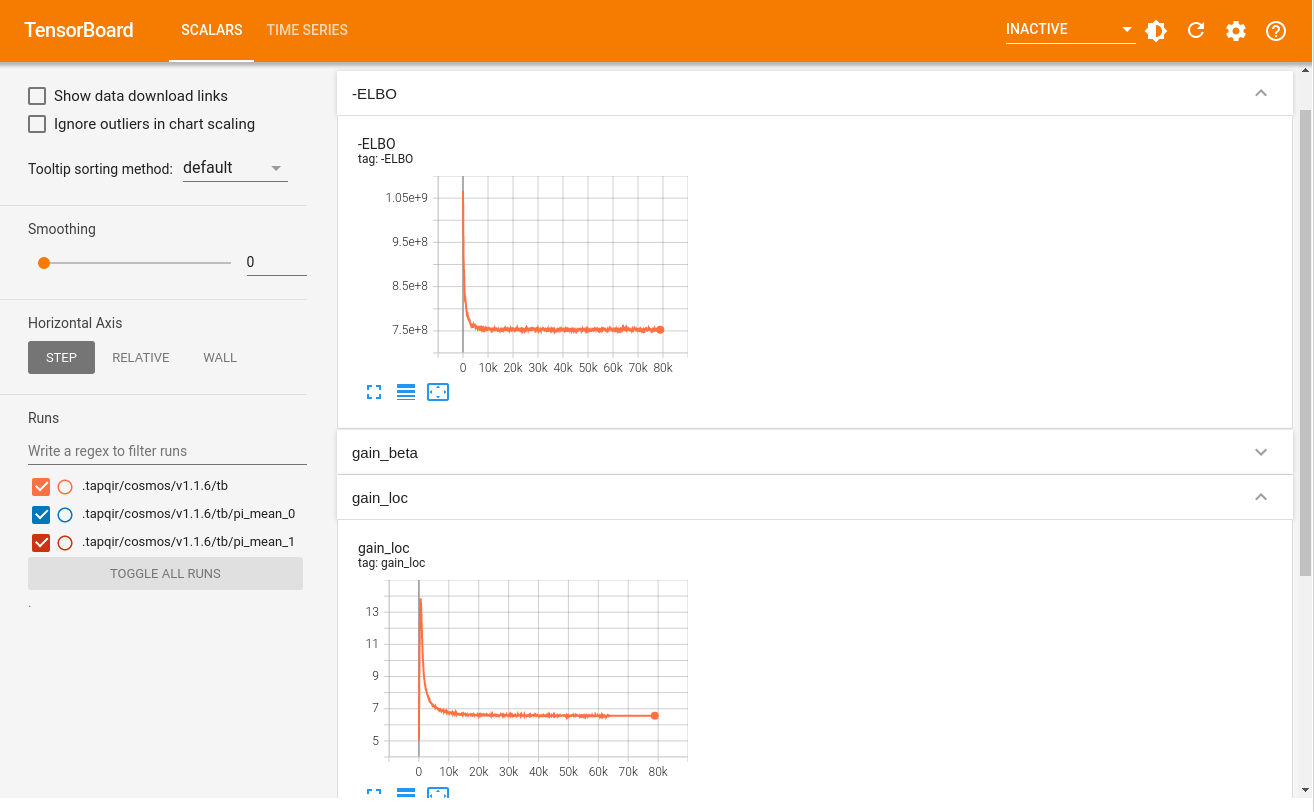

In [ ]:
from IPython.display import Image

Image("http://centaur.biochem.brandeis.edu/tensorboard.png", width=1200)

### Posterior distributions

Model variational parameters are saved in `.tapqir` folder. To obtain 95% credible intervals use `tapqir stats` command which will save the output in `cosmos-params.tpqr` file (PyTorch format). Use `--matlab` flag to save the output in Matlab format as well (`cosmos-params.mat` file). Additionally, values of global model parameters are also saved in `cosmos-summary.csv` file which is easier to access (with Excel or any text editor).

In [ ]:
# use stats command to calculate 95% credible intervals
!tapqir stats cosmos --matlab

INFO - Tapqir version - v1.1.6+545.g4212126
INFO - Model - cosmos
INFO - Device - cpu
INFO - Floating precision - torch.float64
INFO - Loaded data from /content/drive/My Drive/Rpb1SNAP549/data.tpqr
INFO - Device - cpu
INFO - Floating precision - torch.float64
tcmalloc: large alloc 2282577920 bytes == 0x56438c2f4000 @  0x7fa8799e1b6b 0x7fa879a01379 0x7fa81debd26e 0x7fa81debe9e2 0x7fa861728b49 0x7fa861729897 0x7fa861b05d89 0x7fa86226ab9a 0x7fa86224dcbe 0x7fa861e52a05 0x7fa861b09df0 0x7fa8623dcb94 0x7fa86223abf4 0x7fa862250fb7 0x7fa861eac171 0x7fa861907891 0x7fa86228b0e6 0x7fa86228cecb 0x7fa8622398a2 0x7fa86218c4dc 0x7fa8639f326e 0x7fa8639f37ae 0x7fa861ddd423 0x7fa874815f8d 0x5643322804b0 0x564332280240 0x5643322f40f3 0x564332281afa 0x5643322ef915 0x5643322ee9ee 0x564332281bda
tcmalloc: large alloc 2282577920 bytes == 0x5644143ca000 @  0x7fa8799e1b6b 0x7fa879a01379 0x7fa81debd26e 0x7fa81debe9e2 0x7fa861728b49 0x7fa861729897 0x7fa861b05d89 0x7fa8622a2966 0x7fa8617137fb 0x7fa861714c33 0x7fa

Let's look into our folder to confirm that parameters have been saved:

In [ ]:
|%ls -alh

total 1.3G
drwxr-xr-x 4 root root 4.0K Sep 20 20:41 ./
drwxr-xr-x 1 root root 4.0K Sep 20 19:41 ../
-rw-r--r-- 1 root root  75M Sep 20 20:41 cosmos-params.mat
-rw-r--r-- 1 root root  77M Sep 20 20:41 cosmos-params.tpqr
-rw-r--r-- 1 root root 1.1G Sep 20 19:42 data.tpqr
drwxr-xr-x 3 root root 4.0K Aug 20 19:39 Rpb1SNAP549_glimpse/
-rw-r--r-- 1 root root  361 Sep 20 20:41 statistics.csv
drwxr-xr-x 3 root root 4.0K Sep 20 19:43 .tapqir/


## References

[1] Rosen GA, Baek I,Friedman LJ, Joo YJ, Buratowski S,Gelles J. Dynamics of RNA polymerase II and elongation factor Spt4/5 recruitment during activator-dependent transcription. Proc Natl Acad Sci U S A. 2020 Dec; 117(51):32348–32357. doi: [10.1073/pnas.2011224117](https://dx.doi.org/10.1073/pnas.2011224117).

[2] Friedman LJ, Gelles J. Multi-wavelength single-molecule fluorescence analysis of transcription mechanisms. Methods. 2015 Sep; 86:27–36. doi: [10.1016/j.ymeth.2015.05.026](https://dx.doi.org/10.1016/j.ymeth.2015.05.026). CoSMoS Wiki: <https://github.com/gelles-brandeis/CoSMoS_Analysis/wiki>

[3] Ordabayev YA, Friedman LJ, Gelles J, Theobald DL. Bayesian machine learning analysis of single-molecule fluorescence colocalization images. bioRxiv. 2021 Oct. doi: [10.1101/2021.09.30.462536](https://doi.org/10.1101/2021.09.30.462536).